##### LINE BOT 串接 OpenAI ChatGPT ( 上下文歷史紀錄 )
單純使用 ChatGPT API 做出來的 LINE BOT，通常不具備閱讀歷史紀錄來讓上下文連貫的功能，但如果搭配 Firebase Realtime database 作為資料庫，\
就能將過去聊天的歷史紀錄作為訊息內容，讓 LINE BOT 也能具備連貫上下文的功能，這篇教學會介紹如何實作這個應用。

參考下列文章，建立 Firebase Realtime database 以及熟悉相關技術。
* [建立 Firebase RealTime Database](https://steam.oxxostudio.tw/category/python/example/firebase-1.html)
* [設定 Firebase RealTime Database 安全規則](https://steam.oxxostudio.tw/category/python/example/firebase-2.html)
* [串接 Firebase RealTime Database 存取資料](https://steam.oxxostudio.tw/category/python/example/firebase-3.html)
* [ChatGPT 串接 Firebase，實現上下文歷史紀錄](https://steam.oxxostudio.tw/category/python/example/openai-firebase.html)

##### 本機環境或 Colab 
參考「自動回覆訊息」文章，使用 Anaconda Jupyter 或本機環境執行下方的程式碼，並搭配 ngrok 服務，\
建立 LINE Webhook URL，執行後發送訊息到 LINE BOT，應該就能看到 LINE BOT 回覆一模一樣的訊息。

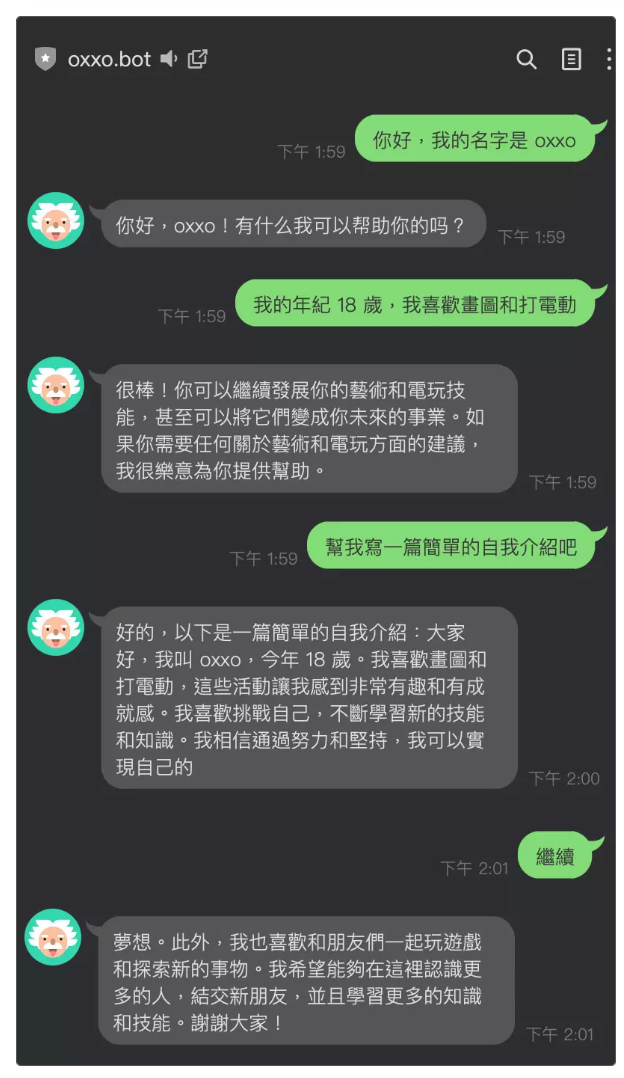

In [14]:
import os
from flask import Flask, request
from linebot import LineBotApi
from linebot.v3.webhook import WebhookHandler
from linebot.models import TextSendMessage
import json
from openai import OpenAI

openai_api_key = ''  # 你的 OpenAI API KEY

client = OpenAI(
    api_key=openai_api_key,
)

app = Flask(__name__)

@app.route("/", methods=['POST'])
def linebot():
    body = request.get_data(as_text=True)
    json_data = json.loads(body)
    print(json_data)
    try:
        token = ''  # 你的 Access Token
        secret = ''  # 你的 Channel Secret
        line_bot_api = LineBotApi(token)
        handler = WebhookHandler(secret)
        signature = request.headers['X-Line-Signature']
        handler.handle(body, signature)
        tk = json_data['events'][0]['replyToken']  # 回覆的 reply token
        msg_type = json_data['events'][0]['message']['type']  # 訊息類型

        # 如果是文字訊息
        if msg_type == 'text':
            msg = json_data['events'][0]['message']['text']  # 取出文字內容

            # 使用本地變數來保存對話歷史紀錄
            if 'chatgpt' not in globals():
                global chatgpt
                chatgpt = []
            if msg == '!reset':
                chatgpt = []  # 如果收到 !reset 的訊息，表示清空歷史紀錄
                reply_msg = TextSendMessage(text='對話歷史紀錄已經清空！')
            else:
                chatgpt.append({"role": "user", "content": msg})  # 如果是一般文字訊息，將訊息添加到歷史紀錄裡
                response = client.chat.completions.create(
                    messages=chatgpt,
                    model="gpt-3.5-turbo",
                    max_tokens=128,
                    temperature=0.5
                )
                ai_msg = response.choices[0].message['content'].strip()  # 移除回應裡的換行符
                chatgpt.append({"role": "assistant", "content": ai_msg})  # 歷史紀錄裡添加回應訊息
                reply_msg = TextSendMessage(text=ai_msg)  # 回應訊息
            line_bot_api.reply_message(tk, reply_msg)
    except Exception as e:
        print(e)
    return 'OK'

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


{'destination': 'Ub17b800f76069234dee4047f531d297b', 'events': [{'type': 'message', 'message': {'type': 'text', 'id': '519303640877105153', 'quoteToken': '_eXYraywnG7z6EyJmCmwgV8u5f8ctlwNV0DmtGIMOEJccOsuGXXeLLws_5dOXPml3k-LTmXSSdJzvlz2J9iuZIL8mP7tUQSA8GkgTQwG1seYq1aF5jDvGOiMxyUH5TrbOib9dcp7mzm6X_aY9yFF5g', 'text': '天哪'}, 'webhookEventId': '01J42AVWRB29ASVNJRXZ3Y8YDS', 'deliveryContext': {'isRedelivery': False}, 'timestamp': 1722360394460, 'source': {'type': 'user', 'userId': 'U572c58f09727779c13d85fe7a6b0415f'}, 'replyToken': '5277dc3644b94b0bb5776c8510a27d93', 'mode': 'active'}]}


C:\Users\cgiks\AppData\Local\Temp\ipykernel_9844\1754549670.py:25: LineBotSdkDeprecatedIn30: Call to deprecated class LineBotApi. (Use v3 class; linebot.v3.<feature>. See https://github.com/line/line-bot-sdk-python/blob/master/README.rst for more details.) -- Deprecated since version 3.0.0.
  line_bot_api = LineBotApi(token)
127.0.0.1 - - [31/Jul/2024 01:26:38] "POST / HTTP/1.1" 200 -


Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}


##### 部署到 Google Cloud Functions 
參考「[使用 Cloud Functions 建立 Webhook](https://steam.oxxostudio.tw/category/python/example/line-webhook.html#a5)」教學，建立並進入 Google Cloud Functions 專案，點擊 requirements.txt，輸入下列資訊。

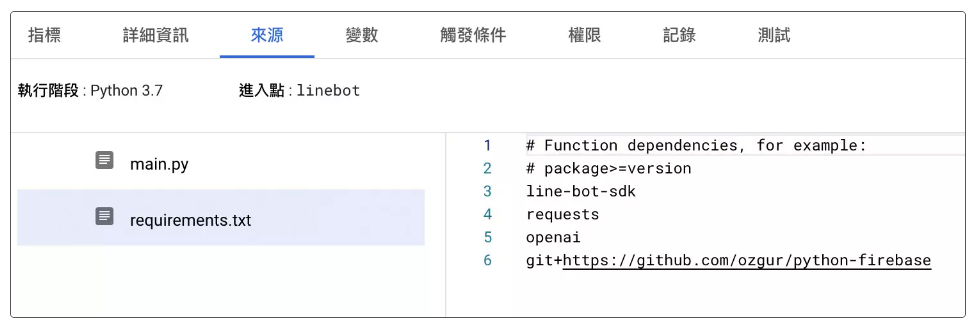

In [ ]:
# Function dependencies, for example:
# package>=version
line-bot-sdk
requests
openai
git+https://github.com/ozgur/python-firebase

將下列的程式碼貼入 main.py，輸入自己的 LINE Access Token、Channel Secret、OpenAI API Key、Firebase 網址。

In [ ]:
from linebot import LineBotApi, WebhookHandler
from linebot.models import TextSendMessage, StickerSendMessage, ImageSendMessage, LocationSendMessage
import requests, json

import openai
openai.api_key = 'API KEY'

from firebase import firebase

token = '你的 Access Token'
secret = '你的 Channel Secret'

def linebot(request):
    body = request.get_data(as_text=True)
    json_data = json.loads(body)
    try:
        line_bot_api = LineBotApi(token)
        handler = WebhookHandler(secret)
        signature = request.headers['X-Line-Signature']
        handler.handle(body, signature)
        tk = json_data['events'][0]['replyToken']
        timestamp = json_data['events'][0]['timestamp']
        msg_type = json_data['events'][0]['message']['type']
        if msg_type == 'text':
            msg = json_data['events'][0]['message']['text']
            url = 'XXXXXXXXXXX.firebaseio.com'
            fdb = firebase.FirebaseApplication(url, None)
            chatgpt = fdb.get('/','chatgpt')

            if chatgpt == None:
                messages = []
            else:
                messages = chatgpt

            if msg == '!reset':
                reply_msg = TextSendMessage(text='對話歷史紀錄已經清空！')
                line_bot_api.reply_message(tk,reply_msg)
                fdb.delete('/','chatgpt')
            else:
                messages.append({"role":"user","content":msg})
                response = openai.ChatCompletion.create(
                    model="gpt-3.5-turbo",
                    max_tokens=128,
                    temperature=0.5,
                    messages=messages
                )
                ai_msg = response.choices[0].message.content.replace('\n','')
                messages.append({"role":"assistant","content":ai_msg})
                reply_msg = TextSendMessage(text=ai_msg)
                line_bot_api.reply_message(tk,reply_msg)
                fdb.put_async('/','chatgpt',messages)
        else:
            reply_msg = TextSendMessage(text='你傳的不是文字訊息呦')
            line_bot_api.reply_message(tk,reply_msg)
    except Exception as e:
        detail = e.args[0]
        print(detail)
    return 'OK'

部署成功後會看到綠色勾勾，複製觸發網址，回到 LINE Developer 裡更新 Webhook URL。

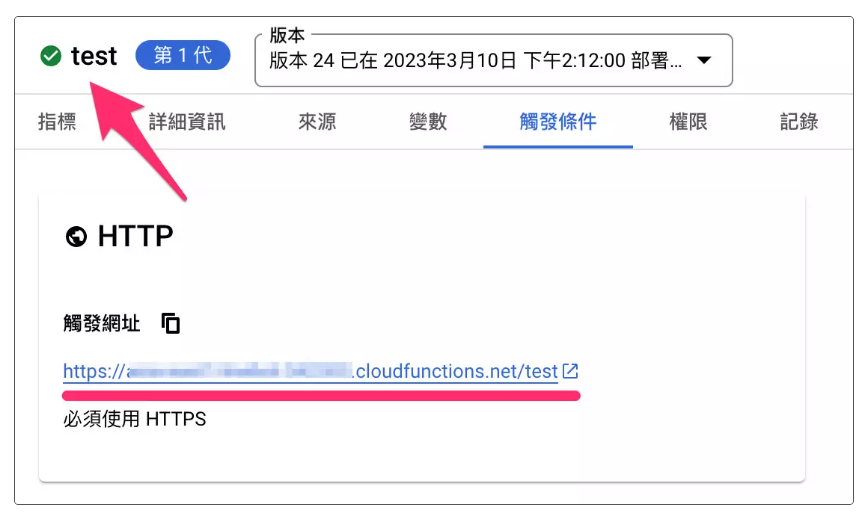

回到 LINE 開始與 LINE BOT 聊天，就會發現 LINE BOT 會記得之前的聊天內容，並根據之前的聊天內容進行回覆。

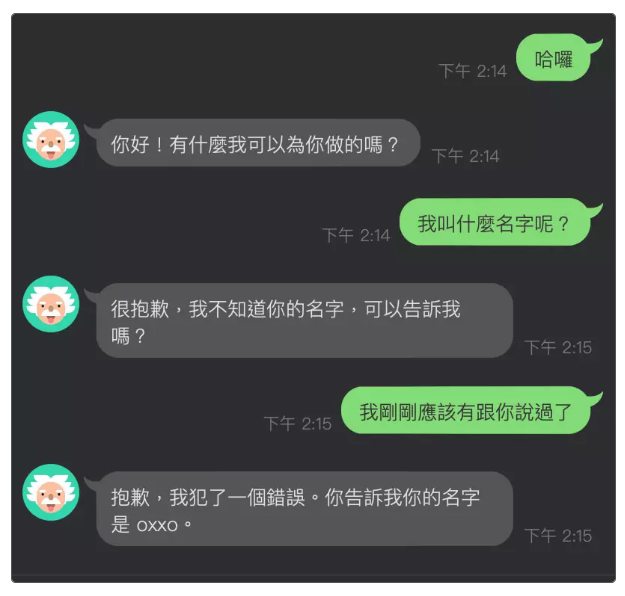

##### 小結 
一旦 LINE BOT 搭配 OpenAI ChatGPT 可以根據聊天記錄進行回覆，就會更有和真人聊天的感覺，但相對了開始傳送聊天記錄後，訊息 token 就會暴增，\
當免費額度用光之後就要開始付費囉。